In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay , classification_report , accuracy_score ,precision_recall_curve , roc_curve ,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib as plt
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

In [7]:
df = pd.read_csv('./data.csv')
vars = df.iloc[:, 2:-1]
# vectorize the target data. M = 1 and B = 0 diagnosis
target = df.iloc[:, 1].apply(lambda x: 1 if x == 'M' else 0)

In [8]:
X = vars
y = target
# Use ANOVA F-value as the scoring function for feature selection 
# f_classif is specify we using ANOVA
# k is the number of features we want to get
selector = SelectKBest(score_func=f_classif, k=15)
# Fit the selector to the data
selector.fit(vars, target)
# Get the scores and p-values of each feature
scores = selector.scores_
p_values = selector.pvalues_

results = pd.DataFrame({'Feature': vars.columns, 'Score': scores, 'p-value': p_values})
results.sort_values(by='Score', ascending=False, inplace=True)
# Select the top K features based on the scores
top_features = vars.columns[selector.get_support()]
# Display the top features
print(top_features)
print(results)

Index(['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean',
       'concavity_mean', 'concave points_mean', 'radius_se', 'perimeter_se',
       'area_se', 'radius_worst', 'perimeter_worst', 'area_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')
                    Feature       Score        p-value
27     concave points_worst  964.385393  1.969100e-124
22          perimeter_worst  897.944219  5.771397e-119
7       concave points_mean  861.676020  7.101150e-116
20             radius_worst  860.781707  8.482292e-116
2            perimeter_mean  697.235272  8.436251e-101
23               area_worst  661.600206   2.828848e-97
0               radius_mean  646.981021   8.465941e-96
3                 area_mean  573.060747   4.734564e-88
6            concavity_mean  533.793126   9.966556e-84
26          concavity_worst  436.691939   2.464664e-72
5          compactness_mean  313.233079   3.938263e-56
25        compactness_worst  

In [9]:
X = X.loc[:,top_features]
X

,radius_mean,perimeter_mean,area_mean,compactness_mean,concavity_mean,concave points_mean,radius_se,perimeter_se,area_se,radius_worst,perimeter_worst,area_worst,compactness_worst,concavity_worst,concave points_worst
0,17.99,122.80,1001.0,0.27760,0.30010,0.14710,1.0950,8.589,153.40,25.380,184.60,2019.0,0.66560,0.7119,0.2654
1,20.57,132.90,1326.0,0.07864,0.08690,0.07017,0.5435,3.398,74.08,24.990,158.80,1956.0,0.18660,0.2416,0.1860
2,19.69,130.00,1203.0,0.15990,0.19740,0.12790,0.7456,4.585,94.03,23.570,152.50,1709.0,0.42450,0.4504,0.2430
3,11.42,77.58,386.1,0.28390,0.24140,0.10520,0.4956,3.445,27.23,14.910,98.87,567.7,0.86630,0.6869,0.2575
4,20.29,135.10,1297.0,0.13280,0.19800,0.10430,0.7572,5.438,94.44,22.540,152.20,1575.0,0.20500,0.4000,0.1625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,142.00,1479.0,0.11590,0.24390,0.13890,1.1760,7.673,158.70,25.450,166.10,2027.0,0.21130,0.4107,0.2216
565,20.13,131.20,1261.0,0.10340,0.14400,0.09791,0.7655,5.203,99.04,23.690,155.00,1731.0,0.19220,0.3215,0.1628
566,16.60,108.30,858.1,0.10230,0.09251,0.05302,0.4564,3.425,48.55,18.980,126.70,1124.0,0.30940,0.3403,0.1418
567,20.60,140.10,1265.0,0.27700,0.35140,0.15200,0.7260,5.772,86.22,25.740,184.60,1821.0,0.86810,0.9387,0.2650


<Axes: title={'center': 'red: ckd, green: not-ckd'}, xlabel='PCA component 1', ylabel='PCA component 2'>

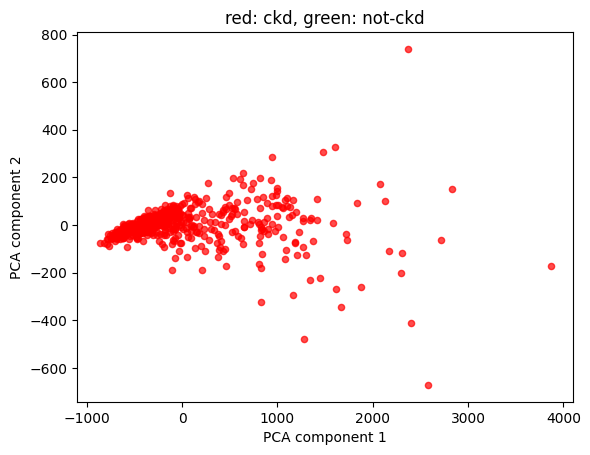

In [10]:
draw = X.loc[:, top_features]
draw = pd.merge(X, y, left_index=True, right_index=True)
pca = PCA(n_components=2)
pca.fit(draw)
T = pca.transform(draw)
T = pd.DataFrame(T)

# plot the data
T.columns = ['PCA component 1', 'PCA component 2']
T.plot.scatter(x='PCA component 1', y='PCA component 2',
	marker='o', alpha=0.7, color="red",
    title="red: ckd, green: not-ckd" )

In [11]:
# Stratify: split the training and testing by 80/20
train_features, test_features, train_targets, test_targets = train_test_split(X, y, train_size=0.8,test_size=0.2,stratify = y)

In [12]:
hyperparameters = [
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
     'C' : np.logspace(-4, 4, 20),
     'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
     'max_iter' : [100, 1000, 2500, 5000]
     }
]
log_model = LogisticRegression()
clf = GridSearchCV(log_model, param_grid = hyperparameters, cv = 3, n_jobs=-1)
clf.fit(train_features, train_targets)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Pytho

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'max_iter': [100, 1000, 2500, 5000],
                          'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                          'solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag',
                                     'saga']}])

In [13]:
display(clf.best_params_)
display(clf.best_estimator_)
display(clf.best_index_)
display(clf.best_score_)

{'C': 3792.690190732246,
 'max_iter': 1000,
 'penalty': 'l2',
 'solver': 'newton-cg'}

LogisticRegression(C=3792.690190732246, max_iter=1000, solver='newton-cg')

1466

0.951681770651795

In [14]:
model_1 = LogisticRegression(max_iter=clf.best_params_['max_iter'],C=clf.best_params_['C'],penalty=clf.best_params_['penalty'],solver=clf.best_params_['solver'])
model_1.fit(train_features, train_targets)

LogisticRegression(C=3792.690190732246, max_iter=1000, solver='newton-cg')

In [15]:
prediction = model_1.predict(test_features)

In [16]:
accuracy_score(test_targets, prediction)

0.956140350877193

In [17]:
CM = confusion_matrix(test_targets, prediction)
tp, fp, fn, tn = np.ravel(CM)
p = tp / (tp + fp)
r = tp / (tp + fn)
f1 = (2 * p * r) / (p + r)

In [20]:
hyperparameters = {
    'hidden_layer_sizes': [(25, ), (50,), (100,), (150,), (200,)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [100, 200, 500]
}
nn_model = MLPClassifier()

clf2 = GridSearchCV(nn_model, param_grid=hyperparameters, cv=5)
clf2.fit(train_features, train_targets)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) 

GridSearchCV(cv=5, estimator=MLPClassifier(),
             param_grid={'activation': ['logistic', 'relu'],
                         'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(50,), (100,), (50, 50),
                                                (100, 100)],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [100, 200, 500], 'solver': ['adam']})

In [26]:
best_params = clf2.best_params_
best_score = clf2.best_score_
best_params

{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'adaptive',
 'max_iter': 500,
 'solver': 'adam'}

In [30]:
best_params = clf2.best_params_
best_score = clf2.best_score_
model_1 = MLPClassifier(max_iter=clf2.best_params_['max_iter'],
                        activation=clf2.best_params_['activation'],
                        solver=clf2.best_params_['solver'],
                        hidden_layer_sizes=clf2.best_params_['hidden_layer_sizes'],
                        learning_rate=clf2.best_params_['learning_rate'],
                        alpha=clf2.best_params_['alpha'])
model_1.fit(train_features, train_targets)

MLPClassifier(learning_rate='adaptive', max_iter=500)

In [31]:
prediction2 = model_1.predict(test_features)
accuracy_score(test_targets, prediction2)

0.9649122807017544